In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
# Parameters of the problem and the genetic algorithm
# TSP parameters
grid_size = 10
n_places = 10
# Genetic algorithm parameters
population_size = 50 # Even number
mutation_rate = 0.05
generations = 100
tournament_size = 4
elitism = 0.1

In [25]:
# Places to visit
def places(grid_size,n_places):
    return list(zip(np.random.randint(0,grid_size,n_places),np.random.randint(0,grid_size,n_places)))

In [26]:
# Fitness function
def distance(path):
    return sum(np.sqrt((path[i][0] - path[i+1][0])**2 + (path[i][1] - path[i+1][1])**2) 
               for i in range(len(path)-1))
def fitness(solution):
    return 1 / distance(solution) # shorter distence higher fitness

In [27]:
# Intial Population
def initial_population(places,population_size):
    return [random.sample(places, len(places)) for _ in range(population_size)]

References for:
* **Selection** 
    * Source: Galan, J. M. & Izquierdo, L. R. (2005). Appearances Can Be Deceiving: Lessons Learned Re-Implementing Axelrod's 'Evolutionary Approach to Norms'. Journal of Artificial Societies and Social Simulation 8(3)2. http://jasss.soc.surrey.ac.uk/8/3/2.html
* **Crossover**: 
    * Apuntes Algorítmica. Softcomputing and Soft Computing and Intelligent Information Systems. Universidad de Granada

In [37]:
# Selection (random tournament)
def random_tournament(population, tournament_size):
    selected_for_next_round = []
    for _ in range(len(population)):
        tournament = random.sample(population, tournament_size)
        winner = max(tournament, key=fitness)
        selected_for_next_round.append(winner)
    return selected_for_next_round

In [44]:
# Crossover (ox crossover)
# Ox ccopy
def ox_copy(parent1,parent2,start,end):
    size = min(len(parent1), len(parent2))
    child=parent1.copy() # Lists are always passed by reference in Phyton!
    tmp=parent2.copy()
    tmp.reverse()
    for place in child[start:end]:
        tmp.remove(place)
    for j in range(end,size):
        child[j] = tmp.pop()
    for j in range(0,start):
        child[j] = tmp.pop()
    return child

def ox_crossover(parent1, parent2):
    size = min(len(parent1), len(parent2))
    start, end = sorted(random.sample(range(size), 2))
    child1=ox_copy(parent1,parent2,start,end)
    child2=ox_copy(parent2,parent1,start,end)
    return child1, child2


In [35]:
# Mutation
def mutate(solution, mutation_rate):
    size=len(solution)
    if random.random() < mutation_rate:
        # swap two random positions
        i,j = random.sample(range(size), 2)
        tmp=solution[i]
        solution[i]=solution[j]
        solution[j]=tmp  
    return solution

In [45]:
# Genetic algortihm
def genetic_algorithm(targets, population_size, generations, tournament_size, mutation_rate, elitism):
    population = initial_population(targets,population_size)
    best_solution=max(population, key=fitness)
    fitness_evolution=[]
    fitness_evolution.append(fitness(max(population, key=fitness)))
    
    # Keep simulating generations
    df_simulation = pd.DataFrame({'c%i'%i:[population[i]] for i in range(population_size)})

    for t in range(generations):
        # Elite (not change)
        population = sorted(population,key=fitness)
        population.reverse()
        e = int(elitism*len(population))
        e = e if (e % 2 == 0) else e+1 # even elite number
        elite=population[:e]

        # Selection
        selection = random_tournament(population, tournament_size)
        parents=random.sample(selection, len(selection))
        next_generation = []

        for i in range(0, int(len(parents)/2)):
            parent1 = parents.pop()
            parent2 = parents.pop()
            child1, child2 = ox_crossover(parent1, parent2)
            next_generation.append(mutate(child1,0))
            next_generation.append(mutate(child2,0))
        population = next_generation
        population[:e]=elite
        fitness_evolution.append(fitness(max(population, key=fitness)))
        if fitness(max(population, key=fitness)) > fitness(best_solution):
            best_solution=max(population, key=fitness) 
    
        df_simulation=pd.concat([df_simulation,
                                 pd.DataFrame({'c%i'%i:[population[i]] for i in range(population_size)})],ignore_index=True)

    return best_solution, fitness_evolution, df_simulation

In [53]:
targets=places(grid_size,n_places)
best_solution,fitness_evolution, dfsim = genetic_algorithm(targets, population_size, 
                                                           generations, tournament_size, mutation_rate, 0.5)

0.03672559438671938


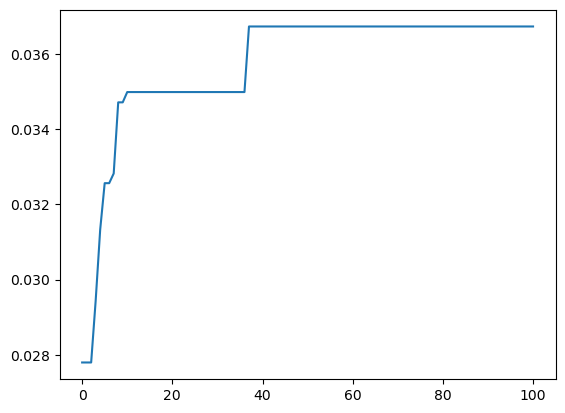

In [54]:
print(fitness(best_solution))
plt.plot(fitness_evolution)

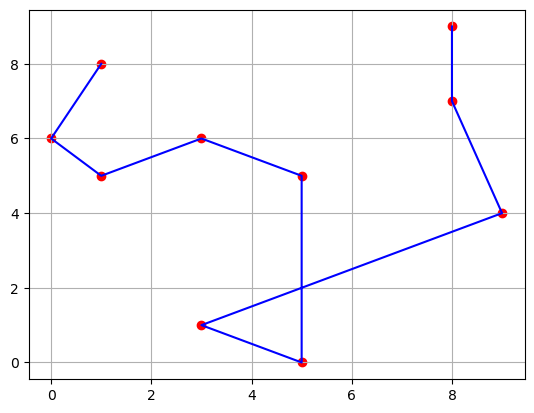

In [55]:
x, y = zip(*best_solution)
plt.scatter(x, y, color='red')
plt.plot(x, y, color='blue')
plt.grid(True)
plt.show()

In [49]:
from bokeh.plotting import figure, show
from bokeh.models import Range1d

In [50]:
# Draw the fitness evolution
x=np.arange(len(fitness_evolution))
y=fitness_evolution
p = figure(width=500, height=500, title="Fitness", tools="", x_axis_label='Generation',
           toolbar_location=None, match_aspect=True)
p.line(x, y, color="navy", alpha=0.4, line_width=4)
p.y_range = Range1d(min(fitness_evolution)-0.0005, max(fitness_evolution)+0.0005)
p.background_fill_color = "#efefef"
show(p)

In [58]:
# Draw solution population
S=int(np.sqrt(population_size)) + 1 
padding=0.1
L=grid_size+2*padding

gen=30
P=dfsim.loc[gen].values.tolist()

p = figure(width=600, height=600, title="Generation %i" %gen, tools="",
           toolbar_location=None, match_aspect=True)

for i in range(S):
    H=i*L + padding 
    for j in range(S):
        W=j*L + padding
        if P:
            solution=P.pop()
            x, y = zip(*solution)
            p.line(np.array(x)+W, np.array(y)+H, color="navy", alpha=0.4, line_width=4)

p.x_range = Range1d(0, L*S)
p.y_range = Range1d(0, L*(S-1))
p.axis.visible = False 
p.background_fill_color = "#efefef"
show(p)